0 of 85281
10000 of 85281
20000 of 85281
30000 of 85281
40000 of 85281
50000 of 85281
60000 of 85281
70000 of 85281
80000 of 85281
85280 of 85281

SUCCESS: Alignment completed


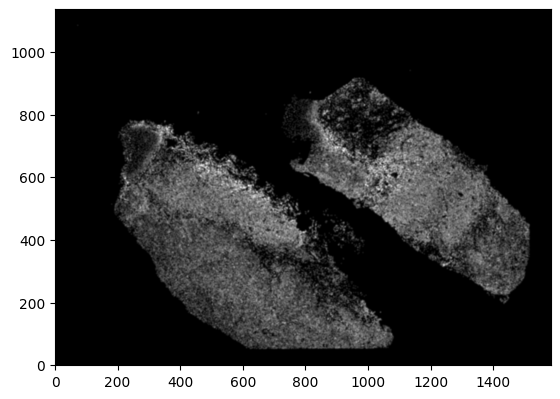

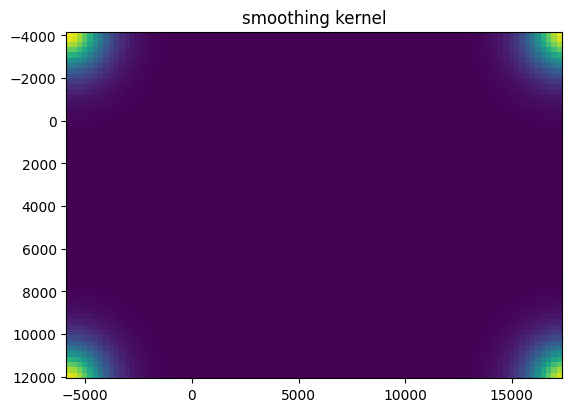

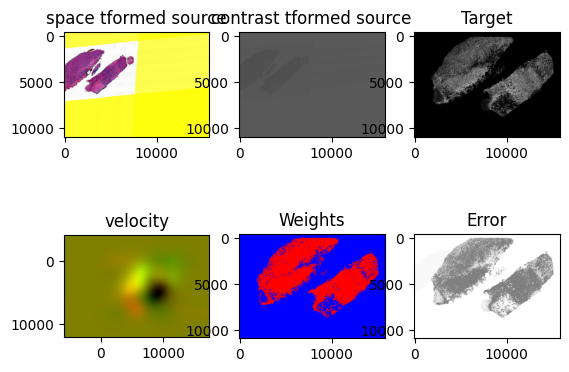

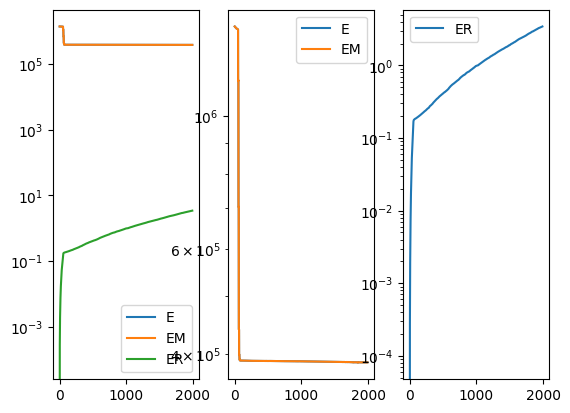

In [1]:
"""
STalign-based H&E to t-CycIF Alignment Pipeline
With GPU Memory Optimizations and Batch Processing
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import scipy.ndimage as ndimage
from pathlib import Path
from STalign import STalign
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration - Update these paths as needed
PATHS = {
    'he_image': Path(r"/media/cruz/TOSHIBA EXT1/virtual_tma/FA/Images/FAHNSCC-14_he.png"),
    'cell_data': Path(r"/media/cruz/TOSHIBA EXT1/virtual_tma/FA/metadata/FAHNSCC_14.csv"),
    'landmarks_he': Path(r"/media/cruz/TOSHIBA EXT1/virtual_tma/FA/point_annotator/points/FAHNSCC_14_HE_points.npy"),
    'landmarks_cycif': Path(r"/media/cruz/TOSHIBA EXT1/virtual_tma/FA/point_annotator/points/FAHNSCC_14_points.npy"),
    'output': Path(r"/media/cruz/TOSHIBA EXT1/virtual_tma/FA/output/FAHNSCC_14_HE.csv.gz")
}

PARAMS = {
    'rotation': 90,
    'raster_resolution': 10,
    'lddmm': {
        'sigmaM': 0.15,
        'sigmaB': 0.10,
        'sigmaA': 0.11,
        'epV': 10,
        'niter': 2000
    },
    'batch': {
        'size': 5000,
        'max_split_size': 128
    }
}

def validate_paths():
    """Validate all paths before processing"""
    errors = []
    
    for key in ['he_image', 'cell_data', 'landmarks_he', 'landmarks_cycif']:
        path = PATHS[key]
        if not path.exists():
            errors.append(f"Missing input file: {str(path)}")
        elif path.is_dir():
            errors.append(f"Expected file but found directory: {str(path)}")

    output_dir = PATHS['output'].parent
    if not output_dir.exists():
        errors.append(f"Output directory does not exist: {str(output_dir)}\nCreate it with:\nmkdir -p '{str(output_dir)}'")
    elif not os.access(output_dir, os.W_OK):
        errors.append(f"Output directory not writable: {str(output_dir)}\nCheck permissions with:\nls -ld '{str(output_dir)}'")

    if errors:
        raise RuntimeError("\n".join(errors))

def configure_gpu():
    """Configure GPU settings for optimal memory usage"""
    if torch.cuda.is_available():
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = f'max_split_size_mb:{PARAMS["batch"]["max_split_size"]}'
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.benchmark = True
        torch.cuda.empty_cache()

def load_he_image(path, rotation=0):
    """Load and preprocess H&E image with memory optimization"""
    try:
        img = plt.imread(str(path))
        if rotation != 0:
            img = ndimage.rotate(img, rotation, reshape=True)
        return STalign.normalize(img.transpose(2,0,1))
    except Exception as e:
        raise RuntimeError(f"Error loading H&E image: {str(e)}")

def load_cell_data(path):
    """Load single-cell data with validation"""
    try:
        df = pd.read_csv(path)
        
        required = ['X_centroid', 'Y_centroid']
        missing = [col for col in required if col not in df.columns]
        if missing:
            raise ValueError(f"Missing columns: {', '.join(missing)}")
            
        return df, np.array(df['X_centroid']), np.array(df['Y_centroid'])
    except Exception as e:
        raise RuntimeError(f"Cell data error: {str(e)}")

def rasterize_cells(x, y, resolution=5):
    """Convert coordinates to rasterized image"""
    XJ, YJ, M, fig = STalign.rasterize(x, y, dx=resolution)
    fig.axes[0].invert_yaxis()
    J = np.vstack((M, M, M))
    return XJ, YJ, STalign.normalize(J)

def load_landmarks(path):
    """Load and convert landmark points"""
    points = np.load(str(path), allow_pickle=True).tolist()
    formatted = []
    for k in points.keys():
        formatted.append([points[k][0][1], points[k][0][0]])
    return np.array(formatted)

def initialize_alignment(points_he, points_cycif):
    """Calculate initial affine transformation"""
    L, T = STalign.L_T_from_points(points_he, points_cycif)
    return L, T


def batch_transform_points(xv, v, A, points, batch_size=5000):
    """Transform points in batches with dtype consistency"""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    all_coords = []
    
    # Ensure transformation parameters are on correct device and dtype
    def ensure_tensor(param, device):
        if isinstance(param, (list, tuple)):
            return [ensure_tensor(p, device) for p in param]
        if not isinstance(param, torch.Tensor):
            param = torch.tensor(param, device=device, dtype=torch.float64)
        return param.to(dtype=torch.float64, device=device)
    
    xv = ensure_tensor(xv, device)
    v = ensure_tensor(v, device)
    A = ensure_tensor(A, device)

    for i in range(0, len(points), batch_size):
        # Keep original float64 dtype from CSV data
        batch_points = points[i:i+batch_size]
        points_tensor = torch.from_numpy(batch_points).to(
            device=device,
            dtype=torch.float64  # Maintain float64 precision
        )
        
        with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision
            batch_coords = STalign.transform_points_target_to_source(
                xv, 
                v, 
                A, 
                points_tensor
            )
            all_coords.append(batch_coords.detach().cpu().numpy())
            
        del points_tensor, batch_coords
        if device == 'cuda':
            torch.cuda.empty_cache()
            
    return np.concatenate(all_coords)


def perform_lddmm_alignment(he_image, cycif_image, L, T, params):
    """Perform optimized non-linear alignment"""
    configure_gpu()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Filter valid LDDMM parameters
    valid_params = {k: v for k, v in params.items() if k in ['sigmaM', 'sigmaB', 'sigmaA', 'epV', 'niter']}
    
    L_tensor = torch.from_numpy(L).float().to(device)
    T_tensor = torch.from_numpy(T).float().to(device)
    
    he_data = torch.from_numpy(he_image['data']).half().to(device)
    cycif_data = torch.from_numpy(cycif_image['data']).half().to(device)

    base_params = {
        'L': L_tensor,
        'T': T_tensor,
        'device': device,
        'muB': torch.tensor([0, 0, 0], dtype=torch.float16, device=device),
        'muA': torch.tensor([1, 1, 1], dtype=torch.float16, device=device)
    }
    base_params.update(valid_params)
    
    try:
        with torch.cuda.amp.autocast():
            return STalign.LDDMM(
                [he_image['Y'], he_image['X']], he_data,
                [cycif_image['Y'], cycif_image['X']], cycif_data,
                **base_params
            )
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print("Falling back to CPU with reduced resolution")
            return perform_cpu_fallback(he_image, cycif_image, L, T, params)
        raise

def perform_cpu_fallback(he_image, cycif_image, L, T, params):
    """CPU fallback implementation with reduced resolution"""
    params['raster_resolution'] *= 2
    XJ, YJ, rasterized = rasterize_cells(
        cycif_image['X'], cycif_image['Y'], 
        params['raster_resolution']
    )
    
    he_data = torch.from_numpy(he_image['data']).float()
    cycif_data = torch.from_numpy(rasterized).float()
    
    return STalign.LDDMM(
        [he_image['Y'], he_image['X']], he_data,
        [YJ, XJ], cycif_data,
        L=L, T=T,
        device='cpu',
        niter=params.get('niter', 1000)
    )

def save_results(df, transformed_coords, output_path):
    """Save results with automatic directory creation"""
    try:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        df['aligned_X'] = transformed_coords[:, 1]
        df['aligned_Y'] = transformed_coords[:, 0]
        
        if output_path.suffix == '.gz':
            df.to_csv(output_path, compression='gzip', index=False)
        else:
            df.to_csv(output_path, index=False)
    except Exception as e:
        raise RuntimeError(f"Failed to save results: {str(e)}")

def visualize_alignment(he_image, original, transformed, output_dir):
    """Generate alignment visualization"""
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].imshow(he_image['data'].transpose(1, 2, 0), extent=STalign.extent_from_x((he_image['Y'], he_image['X'])))
    ax[0].scatter(original[:, 0], original[:, 1], s=1, alpha=0.1, c='red')
    ax[0].set_title('Original Positions')
    
    ax[1].imshow(he_image['data'].transpose(1, 2, 0), extent=STalign.extent_from_x((he_image['Y'], he_image['X'])))
    ax[1].scatter(transformed[:, 1], transformed[:, 0], s=1, alpha=0.1, c='white')
    ax[1].set_title('Aligned Positions')
    
    plt.savefig(output_dir/'alignment_result.png', dpi=300, bbox_inches='tight')
    plt.close()

def main():
    try:
        validate_paths()
        configure_gpu()
        
        # Load data
        he_data = load_he_image(PATHS['he_image'], PARAMS['rotation'])
        YI = np.arange(he_data.shape[1]) * 1.0
        XI = np.arange(he_data.shape[2]) * 1.0
        he_image = {'data': he_data, 'X': XI, 'Y': YI}
        
        df, x_coords, y_coords = load_cell_data(PATHS['cell_data'])
        
        # Rasterize cells
        XJ, YJ, rasterized = rasterize_cells(x_coords, y_coords, PARAMS['raster_resolution'])
        cycif_image = {'data': rasterized, 'X': XJ, 'Y': YJ}
        
        # Alignment
        points_he = load_landmarks(PATHS['landmarks_he'])
        points_cycif = load_landmarks(PATHS['landmarks_cycif'])
        L, T = initialize_alignment(points_he, points_cycif)
        
        result = perform_lddmm_alignment(he_image, cycif_image, L, T, PARAMS['lddmm'])
        
        # Batch transformation
        points = np.stack([y_coords, x_coords], -1)
        transformed_coords = batch_transform_points(
            result['xv'], 
            result['v'], 
            result['A'],
            points,
            PARAMS['batch']['size']
        )
        
        # Save and visualize
        save_results(df, transformed_coords, PATHS['output'])
        visualize_alignment(he_image, points, transformed_coords, PATHS['output'].parent)
        
        print("\nSUCCESS: Alignment completed")

    except Exception as e:
        print(f"\n{' ERROR '.center(50, '=')}")
        print(f"FAILURE: {str(e)}")
        print("\nTroubleshooting steps:")
        print(f"1. Try increasing 'max_split_size' parameter")
        print(f"2. Reduce 'batch_size' in PARAMS['batch']")
        print(f"3. Increase 'raster_resolution' in main PARAMS")
        print('='*50)
        raise

if __name__ == '__main__':
    main()